### Imports

In [1]:
#Imports
from PIL import Image, ImageOps
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [16]:
#Tokenizer to split sentences into a list of words
word_tokenizer = spacy.load("en_core_web_sm")


class Vocabulary():
  """
  Class to convert the captions to index sequential tensors

  Args:
    freq_threshold (int, optional): How many times a word has to appear in dataset before it can be added to the vocabulary. Defaults to 2

  """

  def __init__(self, freq_threshold:int=2):
    self.itos = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"} #index to sentence
    self.stoi = {"<PAD>": 0, "<SOS>":1, "<EOS>": 2, "<UNK>":3} #sentence to index
    self.freq_threshold = freq_threshold #threshold for adding a word to the vocab

  def __len__(self):
    return len(self.itos)

  @staticmethod
  def tokenizer_eng(text):
    #convert sentence to list of words
    return [tok.text.lower() for tok in word_tokenizer.tokenizer(text)] #convert sentence to words


  def build_vocabulary(self, sentence_list):
    frequencies = {}
    idx = 4 #0-3 are for special tokens

    for sentence in sentence_list:
      for word in self.tokenizer_eng(sentence): #convert sentence to words
        if word not in frequencies:
          frequencies[word] = 1
        else:
          frequencies[word] += 1

        if frequencies[word] == self.freq_threshold: #once met freq_threshold, add to vocab list
          self.stoi[word] = idx
          self.itos[idx] = word
          idx += 1

  def numericalize(self, text):
    tokenized_text = self.tokenizer_eng(text) #convert annnotations to labels by converting each word to the index inside the vocab, else UNK tag
    return [
        self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
        for token in tokenized_text
    ]

In [17]:
class CustomDataset(Dataset):

    """
    Class to setup the custom Dataset for pyTorch Dataloader

    Args:
        Note: the order of the csv_file and root_dir are directly related, csv_file[0] contains captions for images in root_dir[0]
        
        csv_file (list): Lists of path to CSV files with annotations.
        root_dir (list): List of directory containing images.
        img_size (tuple, optional): Image size in the format (width, height), defaults to (256,256)
        transform (callable, optional): Optional torchvision transform to be applied on a sample, defaults to None
        freq_threshold (int, optional): Freq threshold for Vocabulary Class, defaults to 2
        vocabulary (Vocabulary, optional): Determines to use an existing vocabulary or create own, defaults to None
    Returns:
        image: transformed image
        labels: tensor object of the labels
        all_image_captions: list containing all the captions of the image
    """

    def __init__(self, csv_file:list, root_dir:list, img_size:tuple=(256,256), transform=None, freq_threshold=2, vocabulary=None):
        
        #dataframe with col name ['image_filename', 'image_captions'] from csv file
        self.annotations = pd.DataFrame()
        #list containing the int boundary on which image path to look at
        #list will containing the num of images in directory which is the boundary
        self.root_dir_boundary = []
        
        for idx, label_files in enumerate(csv_file): 
            labels = pd.read_csv(label_files, index_col=0) #remove index col
            self.annotations = pd.concat([self.annotations, labels], ignore_index=True) #merging annotations into 1 dataset

            #getting the image boundary on which idx belongs to which image file path
            if idx == 0: 
                self.root_dir_boundary.append(len(labels))
            else:
                #get the number of images in root directory and add with the previous to get the range of index that are in this filepath
                self.root_dir_boundary.append(self.root_dir_boundary[idx-1] + len(labels))

        self.root_dir = root_dir
        self.transform = transform
        self.img_size = img_size

        #initialise vocabulary
        if vocabulary == None:
            self.vocab = Vocabulary(freq_threshold)
            self.vocab.build_vocabulary(self.annotations.iloc[:,1].to_list()) #build vocab with all captions
        else:
            self.vocab = vocabulary

    def __len__(self):
        return len(self.annotations)


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.annotations.iloc[idx, 0] #Image name as column 0
        #finding the correct root directory filepath in the list does the image belong to
        image_dir_idx = 0
        while idx >= self.root_dir_boundary[image_dir_idx] and image_dir_idx < len(self.root_dir_boundary):
            image_dir_idx += 1

        img_path = f"{self.root_dir[image_dir_idx]}/{img_name}"

        image = Image.open(img_path)
        # image = ImageOps.pad(image, self.img_size) #resize image
        annotation = self.annotations.iloc[idx, 1] #Annotation as column 1
        
        #converting caption to index tensor
        numercalized_annotations = [self.vocab.stoi["<SOS>"]]
        numercalized_annotations += self.vocab.numericalize(annotation)
        numercalized_annotations.append(self.vocab.stoi["<EOS>"])

        #create list of all captions associated with the image (for BLEU & ROUGE score)
        all_img_captions = self.annotations[self.annotations['image_filename'] == img_name]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(numercalized_annotations), all_img_captions.iloc[:,1].to_list()


In [18]:
class padAnnotations():
  """
  Collate function to pad all caption to the same length as max(len(caption)) in a batch

  Args:
    pad_idx (int): Index Label for the <PAD> token
    batch_first (boolean, optional): Decide if the dataset labels should be batch first
                                     Either returns (batch size, seq length) or (seq length, batch size)
  
  Returns:
    img: batch image object
    labels: batch of tensors of the captions, converted to the same length by adding <PAD>
    all_labels: batch of lists of the captions of the images
  """
  def __init__(self, pad_idx, batch_first = False):
    self.batch_first = batch_first
    self.pad_idx = pad_idx

  def __call__(self, batch):
    imgs = [item[0].unsqueeze(0) for item in batch] 
    imgs = torch.cat(imgs, dim=0)
    labels = [item[1] for item in batch]
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=self.batch_first, padding_value=self.pad_idx)
    all_labels = [item[2] for item in batch]

    return imgs, labels, all_labels

In [19]:
def visualise_img_caption_data(dataloader, batch_size: int, dataset: CustomDataset, num_batches: int = 1, num_samples: int=9):
    """
    Function to visualise the dataset

    Args:
        dataloader (dataloader object): Pytorch dataloader object to visualise
        batch_size (int): Batch Size of dataloader
        dataset (CustomDataset): dataset used to create dataloader (required to get the vocabulary)
        num_batches (int, optional): How many batches to visualise, defaults to 1
        num_samples (int, optional): How many images per batch to visualise, defaults to 9

    Returns:
        Plot of image with its caption and the list of the captions to the image
    """

    for i in range(num_batches):
        train_features, train_labels, train_all_captions = next(iter(dataloader))
        if i == 0:  # Print shape
            print(f"Feature batch shape: {train_features.size()}")
            print(f"Labels batch shape: {train_labels.size()}")
            print(f"All captions batch size: {len(train_all_captions)}")

        for j in range(num_samples):
            #Prepare image to print
            img = train_features[j].squeeze()
            img = np.transpose(img.numpy(), (1, 2, 0))  #Convert from (channel, height, width) to (height, width, channel) for matplotlib

            #Transpose train_labels and handle out of range indices
            label = train_labels[:, j] if train_labels.size(0) != batch_size else train_labels[0]
            string_label = [dataset.vocab.itos[idx] for idx in label.tolist()]
            actual_caption = " ".join([token for token in string_label if token not in ['<PAD>', '<SOS>', '<EOS>']])

            #Create a new plot for each image
            fig, ax = plt.subplots(figsize=(5, 5))
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f'Caption: {actual_caption}\n\nAll Possible Captions:\n' + "\n".join(train_all_captions[j]), loc='left')

            plt.tight_layout()
            plt.show()


In [20]:
image_size = (299,299)
batch_size = 64

#Define transforms for image preprocessing
train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225]),
])

#No data augmentation
eval_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225]),
])

In [21]:
# Actual dataset for this notebook

#Create train dataset
dataset = CustomDataset(csv_file=['../input/Landscape/Train/Labels/Blip_Label_Clean.csv', '../input/Landscape/Train/Labels/Kosmos_Label_Clean.csv', '../input/Flicker8k/Train/Labels/Label.csv'],
                        root_dir=['../input/Landscape/Train/Images', '../input/Landscape/Train/Images', '../input/Flicker8k/Train/Images'],
                        transform=train_transform,
                        img_size=image_size)

#Create val and test dataset, note that
#1. transform uses eval transform with no data augmentation
#2. vocab is the original train dataset vocab (to map the correct index)
val_dataset = CustomDataset(csv_file=['../input/Landscape/Validation/Labels/Blip_Label_Clean.csv', '../input/Landscape/Validation/Labels/Kosmos_Label_Clean.csv', '../input/Flicker8k/Validation/Labels/Label.csv'],
                        root_dir=['../input/Landscape/Validation/Images', '../input/Landscape/Validation/Images', '../input/Flicker8k/Validation/Images'],
                        transform=eval_transform,
                        img_size=image_size,
                        vocabulary=dataset.vocab)

test_dataset = CustomDataset(csv_file=['../input/Landscape/Test/Labels/Blip_Label_Clean.csv', '../input/Landscape/Test/Labels/Kosmos_Label_Clean.csv', '../input/Flicker8k/Test/Labels/Label.csv'],
                        root_dir=['../input/Landscape/Test/Images', '../input/Landscape/Test/Images', '../input/Flicker8k/Test/Images'],
                        transform=eval_transform,
                        img_size=image_size,
                        vocabulary=dataset.vocab)


#create dataloaders, just update the dataset it is from
train_dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        collate_fn = padAnnotations(
                            pad_idx = dataset.vocab.stoi["<PAD>"],
                            batch_first=True
                        ))

val_dataloader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        collate_fn = padAnnotations(
                            pad_idx = dataset.vocab.stoi["<PAD>"],
                            batch_first=True
                        ))

test_dataloader = DataLoader(test_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        collate_fn = padAnnotations(
                            pad_idx = dataset.vocab.stoi["<PAD>"],
                            batch_first=True
                        ))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 299, 299])
Labels batch shape: torch.Size([64, 24])
All captions batch size: 64


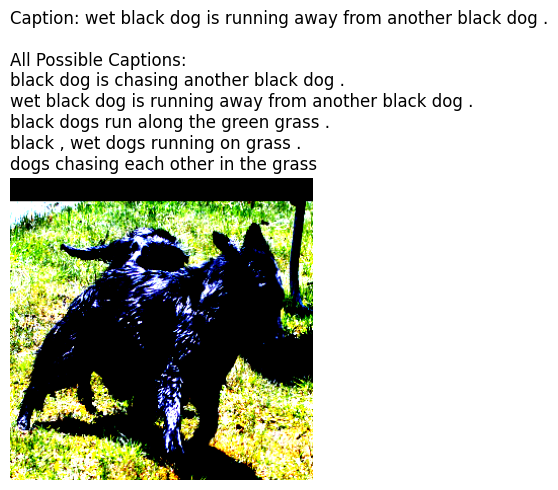

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


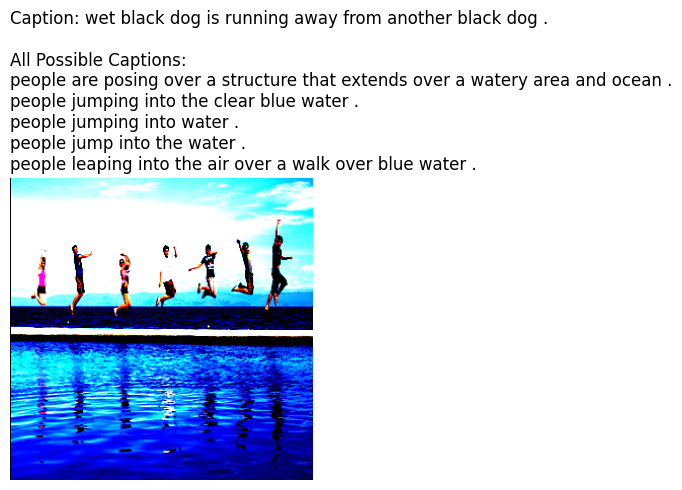

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


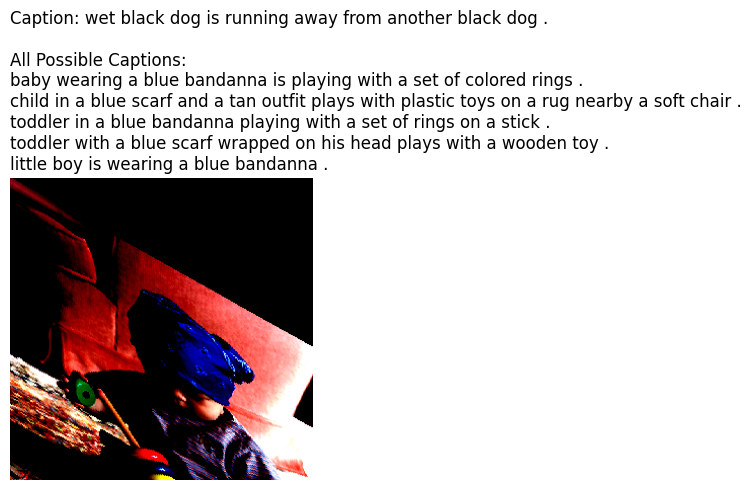

In [22]:
visualise_img_caption_data(train_dataloader, batch_size, dataset, num_samples=3)

### Model

In [23]:
import torch
import torchvision.models as models

In [24]:
class InceptionV3EncoderCNN(torch.nn.Module):
    def __init__(self, pretrained_model):
        super(InceptionV3EncoderCNN, self).__init__()
        if pretrained_model != None:
            self.inception = list(pretrained_model.children())[0]
        
        else:
            self.inception = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
        self.inception.aux_logits = False
        
        #Remove last classification layer
        self.inception.fc = torch.nn.Identity()

        #Variable that will hold the features
        self.features = None
        
        #Register the hook to capture features at output of last CNN layer
        self.inception.Mixed_7c.register_forward_hook(self.capture_features_hook)

        #Prevent training
        for param in self.inception.parameters():
            param.requires_grad_(False)


    def capture_features_hook(self, module, input, output):
        self.features = output #update feature 

    def forward(self, images):
        _ = self.inception(images)  #Pass through the inception network
        batch, feature_maps, size_1, size_2 = self.features.size()  #self.features contain the feature map of size (batch size, 2048, 8,8)
        features = self.features.permute(0, 2, 3, 1)
        features = features.view(batch, size_1*size_2, feature_maps) #resize to (batch size, h*w, feature_maps)

        return features
        

In [25]:
class ResNetEncoderCNN(torch.nn.Module):
    """Encoder inputs images and returns feature maps.
    Arguments:
    ---------
    - image - augmented image sample
    
    Returns:
    ---------
    - features - feature maps of size (batch, height*width, #feature maps)
    """
    def __init__(self, pretrained_model):
        super(ResNetEncoderCNN, self).__init__()

        if pretrained_model != None:
            resnet = list(pretrained_model.children())[0]
        else:
            resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2]
        self.resnet = torch.nn.Sequential(*modules)
        
    def forward(self, images):
        features = self.resnet(images)
        # first, we need to resize the tensor to be 
        # (batch, h*w, feature_maps)
        batch, feature_maps, size_1, size_2 = features.size()       
        features = features.permute(0, 2, 3, 1)
        features = features.view(batch, size_1*size_2, feature_maps)
       
        return features

In [26]:
class BahdanauAttention(torch.nn.Module):

    def __init__(self, feature_dim, hidden_dim, output_dim = 1):
        super(BahdanauAttention, self).__init__()
         # fully-connected layer to learn first weight matrix Wa
        self.W_a = torch.nn.Linear(feature_dim, hidden_dim)
        # fully-connected layer to learn the second weight matrix Ua
        self.U_a = torch.nn.Linear(hidden_dim, hidden_dim)
        # fully-connected layer to produce score (output), learning weight matrix va
        self.v_a = torch.nn.Linear(hidden_dim, output_dim)


    def forward(self, features, hidden_state):
        """
        Args:
            features - image features from Encoder
            hidden_state - hidden state output from Decoder

        Returns:
            context - context vector with size (1,2048)
            atten_weights - probabilities of feature relevance 
        """
        #add additional dimension to a hidden (required for summation) 
        hidden_state = hidden_state.unsqueeze(1) #(batch size, 1, seq length)

        atten_1 = self.W_a(features) #(batch size, h*w, hidden_dim)
        atten_2 = self.U_a(hidden_state) #(batch size, 1, hidden_dim)

        #apply tangent to combine result from 2 fc layers
        atten_tan = torch.tanh(atten_1+atten_2)
        atten_score = self.v_a(atten_tan) #(batch size, hidden_dim)
        atten_weight = torch.nn.functional.softmax(atten_score, dim = 1) #get softmax probablilities

        #multiply each vector with its softmax score and sum to get attention context vector
        context = torch.sum(atten_weight * features,  dim = 1) #size of context equals to a number of feature maps
        atten_weight = atten_weight.squeeze(dim=2)
        
        return context, atten_weight

In [27]:
class DecoderRNN(torch.nn.Module):
  
     def __init__(self, feature_dim, embedding_dim, hidden_dim, vocab_size, drop_prob=0.5, sample_temp=0.5):
          super(DecoderRNN, self).__init__()
          
          self.feature_dim = feature_dim
          self.embedding_dim = embedding_dim
          self.hidden_dim = hidden_dim
          self.vocab_size = vocab_size
          self.sample_temp = sample_temp #scale the inputs b4 softmax

          #layers

          #embedding layer that turns words into index 
          self.embeddings = torch.nn.Embedding(vocab_size, embedding_dim)
          #lstm layer that takes in feature + embedding (image + caption) and output hidden_dim
          self.lstm = torch.nn.LSTMCell(embedding_dim + feature_dim, hidden_dim)
          #fc linear layer that predicts next word
          self.fc = torch.nn.Linear(hidden_dim, vocab_size)
          #attention layer
          self.attention = BahdanauAttention(feature_dim, hidden_dim)
          #dropout layer
          self.drop = torch.nn.Dropout(p=drop_prob)
          #initialisation of fully-connected layers
          self.init_h = torch.nn.Linear(feature_dim, hidden_dim) #initiialising hidden state and cell memory using avg of feature
          self.init_c = torch.nn.Linear(feature_dim, hidden_dim)

     def init_hidden(self, features):
          """
          Initializes hidden state and cell memory using average feature vector.
          Retruns:
          ----------
          - h0 - initial hidden state (short-term memory)
          - c0 - initial cell state (long-term memory)
          """
          mean_annotations = torch.mean(features, dim = 1) #getting average of the features
          h0 = self.init_h(mean_annotations)
          c0 = self.init_c(mean_annotations)
          return h0, c0

     def forward(self,features, captions, device, sample_prob=0.5):
          embed = self.embeddings(captions)
          h,c = self.init_hidden(features)
          batch_size = captions.size(0) #captions: (batch size, seq length)
          seq_len = captions.size(1) 
          feature_size = features.size(1) #features: (batch size, size, 2048)

          #storage of outputs and attention weights of lstm
          outputs = torch.zeros(batch_size, seq_len, self.vocab_size).to(device)
          atten_weights = torch.zeros(batch_size, seq_len, feature_size).to(device)

          #scheduled sampling for training, using the models output to train instead of using the true output
          #autoregressive RNN training, only when length of seq > 1 (cannot be first word)
          for t in range(seq_len):
               s_prob = 0.0 if t==0 else sample_prob
               use_sampling = np.random.random() < s_prob

               if not use_sampling: #no sampling
                    word_embeddings = embed[:, t, :] #embedding until word t
               
               context, atten_weight = self.attention(features,h)
               inputs = torch.cat([word_embeddings, context], 1) #embed captions and features for next lstm state
               h, c = self.lstm(inputs, (h,c)) #pass through lstm
               output = self.fc(self.drop(h))
               
               if use_sampling: #using predicted word instead of true output
                    scaled_output = output/self.sample_temp #using scaling temp to amplify the values
                    #this way softmax will have a larger difference in values
                    #makes the model more selective of whats its picking 
                    
                    scoring = torch.nn.functional.log_softmax(scaled_output, dim=1)
                    top_idx = scoring.topk(1)[1]
                    word_embeddings = self.embeddings(top_idx).squeeze(1) #update word embeddings with predicted instead of actual
               
               #update results
               outputs[:,t,:] = output
               atten_weights[:, t, :] = atten_weight

          return outputs, atten_weights




In [28]:
class ResNetEncoderAttentionDecoder(torch.nn.Module):
    def __init__(self, pretrained_model, feature_size, embedding_dim, hidden_dim, vocab_size, device, drop_prob=0.5, sample_temp=0.5):
        super(ResNetEncoderAttentionDecoder, self).__init__()
        self.encoder = ResNetEncoderCNN(pretrained_model)
        self.decoder= DecoderRNN(feature_size, embedding_dim, hidden_dim, vocab_size, drop_prob, sample_temp)
        self.sample_temp = sample_temp
        self.device = device

    def forward(self, image, captions):
        features = self.encoder(image)
        outputs, atten_weights = self.decoder(features, captions, self.device, self.sample_temp)
        return outputs, atten_weights
    

    #for inference
    def caption_image(self, image, vocabulary, device, max_length=50):
        self.encoder.eval()

        result_caption = []
        result_weights = []

        with torch.no_grad(): #no training
            input_word = torch.tensor(1).unsqueeze(0).to(device)
            result_caption.append(1)
            features = self.encoder(image)
            h, c = self.decoder.init_hidden(features)

            for _ in range(max_length):
                embedded_word = self.decoder.embeddings(input_word)
                context, atten_weight = self.decoder.attention(features, h)
                # input_concat shape at time step t = (batch, embedding_dim + context size)
                input_concat = torch.cat([embedded_word, context],  dim = 1)
                h, c = self.decoder.lstm(input_concat, (h,c))
                h = self.decoder.drop(h)
                output = self.decoder.fc(h) 
                scoring = torch.nn.functional.log_softmax(output, dim=1)
                top_idx = scoring[0].topk(1)[1]
                result_caption.append(top_idx.item())
                result_weights.append(atten_weight)
                input_word = top_idx

                if (len(result_caption) >= max_length or vocabulary.itos[input_word.item()] == "<EOS>"):
                    break

            return [vocabulary.itos[idx] for idx in result_caption], result_weights


In [29]:
class InceptV3EncoderAttentionDecoder(torch.nn.Module):
    def __init__(self, pretrained_model, feature_size, embedding_dim, hidden_dim, vocab_size, device, drop_prob=0.5, sample_temp=0.5):
        super(InceptV3EncoderAttentionDecoder, self).__init__()
        self.encoder = InceptionV3EncoderCNN(pretrained_model)
        self.decoder= DecoderRNN(feature_size, embedding_dim, hidden_dim, vocab_size, drop_prob, sample_temp)
        self.sample_temp = sample_temp
        self.device = device

    def forward(self, image, captions):
        features = self.encoder(image)
        outputs, atten_weights = self.decoder(features, captions, self.device, self.sample_temp)
        return outputs, atten_weights
    
    #for inference
    def caption_image(self, image, vocabulary, device, max_length=50):
        self.encoder.eval()

        result_caption = []
        result_weights = []

        with torch.no_grad(): #no training
            input_word = torch.tensor(1).unsqueeze(0).to(device)
            result_caption.append(1)
            features = self.encoder(image)
            h, c = self.decoder.init_hidden(features)

            for _ in range(max_length):
                embedded_word = self.decoder.embeddings(input_word)
                context, atten_weight = self.decoder.attention(features, h)
                # input_concat shape at time step t = (batch, embedding_dim + context size)
                input_concat = torch.cat([embedded_word, context],  dim = 1)
                h, c = self.decoder.lstm(input_concat, (h,c))
                h = self.decoder.drop(h)
                output = self.decoder.fc(h) 
                scoring = torch.nn.functional.log_softmax(output, dim=1)
                top_idx = scoring[0].topk(1)[1]
                result_caption.append(top_idx.item())
                result_weights.append(atten_weight)
                input_word = top_idx

                if (len(result_caption) >= max_length or vocabulary.itos[input_word.item()] == "<EOS>"):
                    break

            return [vocabulary.itos[idx] for idx in result_caption], result_weights


### TRAINING Imports

In [30]:
from nltk.translate.bleu_score import corpus_bleu

def get_bleu_score(predicted:list, references:list):
    """
    Calculate the bleu 1-4 score of a corpus

    Args: 
        predicted (list): List of each individual prediction
            eg. [
                    "Transformers Transformers are fast plus efficient", 
                    "Good Morning", 
                    "I am waiting for new Transformers"
                ] 

        references (list): Nested list of references of each prediction

            eg. [
                    [
                        "HuggingFace Transformers are quick, efficient and awesome", 
                        "Transformers are awesome because they are fast to execute"
                    ], 
                    [
                        "Good Morning Transformers", 
                        "Morning Transformers"
                    ], 
                    [
                        "People are eagerly waiting for new Transformer models", 
                         "People are very excited about new Transformers"
                    ]
                ]

    Returns:
        results (dictionary): Dictionary in the format of {"BLEU1":, "BLEU2": ,"BLEU3": ,"BLEU4": }
    """
    #Tokenize the predictions and references
    predicted = [pred.split() for pred in predicted]
    references = [[ref.split() for ref in refs] for refs in references]


    BLEU1 = corpus_bleu(references, predicted, weights=(1, 0, 0, 0))
    BLEU2 = corpus_bleu(references, predicted, weights=(0.5, 0.5, 0, 0))
    BLEU3 = corpus_bleu(references, predicted, weights=(0.33, 0.33, 0.33, 0))
    BLEU4 = corpus_bleu(references, predicted, weights=(0.25, 0.25, 0.25, 0.25))

    return {"BLEU1": BLEU1, "BLEU2": BLEU2, "BLEU3": BLEU3, "BLEU4": BLEU4}

In [31]:
import evaluate

def get_rouge_score(predicted:list, references:list):
    """
    Calculate the rogue1, rogue2, rogueL, rogueLSum scores
        
    Args: 
        predicted (list): List of each individual prediction
            eg. [
                    "Transformers Transformers are fast plus efficient", 
                    "Good Morning", 
                    "I am waiting for new Transformers"
                ] 

        references (list): Nested list of references of each prediction

            eg. [
                    [
                        "HuggingFace Transformers are quick, efficient and awesome", 
                        "Transformers are awesome because they are fast to execute"
                    ], 
                    [
                        "Good Morning Transformers", 
                        "Morning Transformers"
                    ], 
                    [
                        "People are eagerly waiting for new Transformer models", 
                         "People are very excited about new Transformers"
                    ]
                ]

    Returns:
        results (dictionary): Dictionary in the format of {'rouge1': , 'rouge2': , 'rougeL': , 'rougeLsum': }
    
    """
    rouge = evaluate.load('rouge')
    results = rouge.compute(predictions=predicted, references=references)
    return results

In [32]:
def decode_predictions(outputs, batch_first:bool, vocabulary:Vocabulary):
    """
    Function to convert model tensor outputs to sentences

    Args:
        outputs (torch tensor object): Model's output to be decoded, either in size (seq len, batch, vocab_size) or (batch, seq len, vocab_size)
        batch_first (bool): Boolean of if dataloader was configured to batch_first
        vocabulary (Vocabulary): dataset Vocabulary Class for decoding

    Returns:
        list of predicted sentences each corresponding to 1 sample in the batch
            - will be of length (batch_size)
            eg. ['predicted sentence 1 for sample 1', ...'predicted sentence N for sample N']
    
    """

    all_prediction = []
    predicted_tokens = outputs.argmax(-1) #flatten vocab size dimensions
    if not batch_first:
        predicted_tokens = predicted_tokens.T 
    
    for sentence_tokens in predicted_tokens:
        sentence_tokens = sentence_tokens.tolist()

        try:
            #cropping predicted sentence to first EOS
            eos_index = sentence_tokens.index(vocabulary.stoi['<EOS>']) #get first instance of <EOS> to crop sentence accordingly
            predicted_sentence = sentence_tokens[:eos_index]
        except:
            predicted_sentence = sentence_tokens

        try:
            #getting predicted_sentence by remove <SOS>
            predicted_sentence.remove(vocabulary.stoi['<SOS>'])
        except:
            pass
    
        all_prediction.append(" ".join([vocabulary.itos[idx] for idx in predicted_sentence]))

    return all_prediction

In [33]:
def eval(model, 
         criterion, 
         dataloader, 
         batch_first:bool, 
         vocabulary:Vocabulary, 
         device:str):
    """
    Function to evaluate model performance

    Args:
        model: The model that is to be evaluated
        criterion: Loss criterion of the model
        dataloader: validation / test dataset
        batch_first (bool): boolean if dataloader samples tensor are (batch, seq len) or (seq len, batch)
        vocabulary (Vocabulary): dataset vocabulary class
        device (str): cpu or cuda

    Returns:
        avg_val_loss: average validation loss
        Bleu_score: dictionary of BLEU 1-4 score
        Rouge_score: dictionary of Rouge  1,2,L,LSum score
    """
    
    model.eval()

    total_val_loss = 0

    #BLEU predictions container
    predictions = []
    references = []
    
    with torch.no_grad():
        for idx, (imgs, annotations, all_annotations) in enumerate(dataloader):
            #getting img and annotations
            imgs = imgs.to(device)
            annotations = annotations.to(device)
            
            
            if not batch_first:
                #running model prediction
                outputs = model(imgs, annotations[:-1]) #training model to guess the last word
                
                #updating model parameters
                loss = criterion(outputs.reshape(-1, outputs.shape[2]), annotations.reshape(-1)) #reshape output (seq_len, N, vocabulary_size) to (N, vocabulary_size)
            
            if batch_first:
                #running model prediction
                outputs, atten_weights = model(imgs, annotations[:, :-1]) #training model to guess the last word
                targets = annotations[:, 1:]
                #updating model parameters
                loss = criterion(outputs.view(-1, len(vocabulary)), targets.reshape(-1)) #reshape output (seq_len, N, vocabulary_size) to (N, vocabulary_size)
            
            total_val_loss += loss.item()

            #get model predictions and update
            predictions.extend(decode_predictions(outputs, batch_first, vocabulary))

            #update references
            references.extend(all_annotations)

        Bleu_score = get_bleu_score(predictions, references)
        Rouge_score = get_rouge_score(predictions, references)

        return total_val_loss/(idx+1), Bleu_score, Rouge_score


In [35]:
import torch

def train(model, 
          criterion, 
          optimiser, 
          train_dataloader, 
          val_dataloader, 
          batch_first:bool, 
          vocabulary:Vocabulary, 
          device:str, 
          num_epochs:int, 
          show_train_metrics:bool=None, 
          save_every:int=None,
          model_name:str=None, 
          overwrite:bool=False):
    
    """
    Function to train the model
    If change in val loss is less than 0.01 for 2 epochs in a row, stop training

    Args:
        model: The model that is to be evaluated
        criterion: Loss criterion of the model
        optimiser: Optimiser function of the model
        train_dataloader: Train dataset
        val_dataloader: Validation dataset, use None if no Validation dataset
        batch_first (bool): Boolean if dataloader samples tensor are (batch, seq len) or (seq len, batch)
        vocabulary (Vocabulary): Dataset vocabulary class
        device (str): cpu or cuda
        num_epochs (int): Number of epochs for training
        show_train_metrics (bool, optional): Booleon on should calculate BLEU & Rouge score during training, defaults to False
        save_every (int, optional): Save model after every ___ epochs, defaults to None (no saving)
        model_name (str, optional): Model Name to be saved after, required if save_every != None, model will be saved as (model_name)_epoch or just model_name
        overwrite (bool, optional): Boolean on overwriting model saves or saving each specific epoch as a new model, defaults to False
    
    Returns
        train_loss: list of average training loss per epoch
        train_bleu: list of dictionary of training BLEU score per epoch, [] if show_train_metric = False
        train_rouge: list of dictionary of training Rouge score per epoch, [] if show_train_metric = False
        val_loss: list of average validation loss per epoch, [] if val_dataloader = None
        val_bleu: list of dictionary of validation BLEU score per epoch, [] if val_dataloader = None
        val_rouge: list of dictionary of validation Rouge score per epoch, [] if val_dataloader = None
    
    """
    
    #initialise results container
    train_loss = []
    train_bleu = []
    train_rouge = []

    val_loss = []
    val_bleu = []
    val_rouge = []

    for epoch in range(num_epochs):

        total_train_loss = 0

        #BLEU predictions container
        predictions = []
        references = []

        #start model training
        model.train()
        for idx, (imgs, annotations, all_annotations) in enumerate(train_dataloader):
            
            #getting img and annotations
            imgs = imgs.to(device)
            annotations = annotations.to(device)

            print(f'batch first: {batch_first}')

            if not batch_first:
                #running model prediction
                outputs = model(imgs, annotations[:-1]) #training model to guess the last word
                
                #updating model parameters
                loss = criterion(outputs.reshape(-1, outputs.shape[2]), annotations.reshape(-1)) #reshape output (seq_len, N, vocabulary_size) to (N, vocabulary_size)
            
            if batch_first:
                #running model prediction
                outputs, atten_weights = model(imgs, annotations[:, :-1]) #training model to guess the last word
                targets = annotations[:, 1:]
                #updating model parameters
                loss = criterion(outputs.view(-1, len(vocabulary)), targets.reshape(-1)) #reshape output (seq_len, N, vocabulary_size) to (N, vocabulary_size)
            
            optimiser.zero_grad() #remove optimiser gradient
            loss.backward()
            optimiser.step()
            
            #calculate loss and update it for each batch
            total_train_loss += loss.item()

            if show_train_metrics:
                #get model predictions and update
                predictions.extend(decode_predictions(outputs, batch_first, vocabulary))

                #update references
                references.extend(all_annotations)

        if show_train_metrics:   
            #calculating bleu and rouge score
            Bleu_score = get_bleu_score(predictions, references)
            Rouge_score = get_rouge_score(predictions, references)
            train_bleu.append(Bleu_score)
            train_rouge.append(Rouge_score)

        #updating values
        train_loss.append(total_train_loss/(idx+1))

        if val_dataloader != None:
            #validation
            avg_val_loss, val_bleu_score, val_rouge_score = eval(
                                                                model=model,
                                                                criterion=criterion,
                                                                dataloader=val_dataloader,
                                                                batch_first=batch_first,
                                                                vocabulary=vocabulary,
                                                                device=device
                                                            )
            
            val_loss.append(avg_val_loss)
            val_bleu.append(val_bleu_score)
            val_rouge.append(val_rouge_score)

        #printing progress
        if num_epochs <= 10 or (num_epochs >10 and (epoch+1)%5 == 0):
            print(f"Epoch {epoch+1} completed\navg training loss per batch: {total_train_loss/(idx+1)}")
            
            if show_train_metrics:
                print(f"train bleu score:{Bleu_score}\ntrain rouge score: {Rouge_score}\n")

            if val_dataloader != None:
                print(f"avg validation loss per batch: {avg_val_loss}\nval bleu score: {val_bleu_score}\nval rouge score: {val_rouge_score}")

            print("------------------------------------------------------------------")
            
        #saving model every x
        if save_every != None and (epoch+1)%save_every == 0:
            try:
                if overwrite:
                    torch.save(model.state_dict(), f"../models/image_captioning/{model_name}.pt")
                else:
                    torch.save(model.state_dict(), f"../models/image_captioning/{model_name}_{epoch+1}.pt")
            except:
                print(f"Unable to save model at epoch {epoch+1}")

        
        #saving best model
        if (len(val_loss) > 1) and val_loss[-1] < min(val_loss[:-1]):
            try:
                torch.save(model.state_dict(), f"../models/image_captioning/{model_name}_best.pt")
            except:
                print(f"Unable to save best model")
        

        #early stopping
        # if (len(val_loss) >= 3) and abs(val_loss[-2] - val_loss[-1]) < 0.01 and abs(val_loss[-3] - val_loss[-2]) < 0.01:
        #     print(f"validation loss did not decrease, stopping training at epoch {epoch +1}")
        #     try:
        #         if overwrite:
        #             torch.save(model.state_dict(), f"../models/image_captioning/{model_name}.pt")
        #         else:
        #             torch.save(model.state_dict(), f"../models/image_captioning/{model_name}_{epoch+1}.pt")
        #     except:
        #         print(f"Unable to save model at epoch {epoch+1}")
        #     break


    return train_loss, train_bleu, train_rouge, val_loss, val_bleu, val_rouge


### TRAINING

In [36]:
# CLear GPU memory
import gc
torch.cuda.empty_cache()
gc.collect()

210

#### Pretrained Model Imports

In [37]:
class PreTrainedCNNModels(torch.nn.Module):
    def __init__(self, model_type:str, num_unfreeze:int, num_class:int):
        super(PreTrainedCNNModels, self).__init__()
        """
        Class that contains InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit fine tuned models

        Args:
            model_type (str): Determines which pre-trained models to use
                              Must be: InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit
            num_unfreeze (int): Number of layers to unfreeze and finetune
            num_class (int): Number of output classes for the classification
        """
        #selecting model type
        if model_type == 'InceptionV3':
            self.model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
            self.model.aux_logits = False

        elif model_type == 'Resnet50':
            self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        elif model_type == 'Resnet152':
            self.model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)

        elif model_type == 'EfficientNet':
            self.model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)

        elif model_type == 'DenseNet':
            self.model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        
        elif model_type == 'VGG16':
            self.model = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT)

        elif model_type == 'MaxVit':
            self.model = models.maxvit_t(weights=models.MaxVit_T_Weights.DEFAULT)
        
        else:
            raise Exception("Invalid model type chosen. Please select one of the following\n[InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit]")

        
        #modifying final layer
        if model_type in ['InceptionV3', 'Resnet50', 'Resnet152']:
            self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_class)

        elif model_type == 'DenseNet':
            self.model.classifier = torch.nn.Linear(self.model.classifier.in_features, num_class)

        else:
            self.model.classifier[-1] = torch.nn.Linear(self.model.classifier[-1].in_features, num_class)


        model_paramteres = list(self.model.parameters())
        #unfreeze last num_unfreeze layers
        for param in model_paramteres[-num_unfreeze:]:
            param.requires_grad = True

        #freeze rest of the layers
        for param in model_paramteres[:-num_unfreeze]:
            param.requires_grad = False


    def forward(self, images):
        return self.model(images)

### Training with finetuned resnet

In [41]:
pretrained_model = torch.load('../models/cnn/resnet50/resnet50_10_best.pt')

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#hyper parameters
feature_size = 2048
embed_size = 256 
hidden_size = 512
vocab_size = len(dataset.vocab)
num_layers = 3
learning_rate = 3e-4
num_epochs = 50
save_every = 10
model_name = "Flickr_Pretrained_20"


print(device)

cuda


In [43]:
model = ResNetEncoderAttentionDecoder(pretrained_model,
                                      feature_size,
                                      embed_size, 
                                      hidden_size, 
                                      vocab_size, 
                                      device,
                                      0.3,
                                      0).to(device)
criterion = torch.nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [44]:
train_loss, train_bleu, train_rouge, val_loss, val_bleu, val_rouge = train(
    model=model,
    criterion=criterion,
    optimiser=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    batch_first=True,
    vocabulary=dataset.vocab,
    device=device,
    num_epochs=num_epochs,
    show_train_metrics=True,
    save_every=5,
    model_name=model_name,
    overwrite=False
)

batch first: True
outputs
tensor([[[ 8.8159e-02,  1.9481e-01, -1.6313e-01,  ..., -8.7305e-02,
          -1.2501e-01,  4.1234e-03],
         [ 1.6346e-01,  2.3662e-01, -7.1976e-02,  ..., -9.0173e-02,
          -1.3621e-01,  7.0029e-02],
         [ 1.5350e-01,  1.8748e-01,  7.3975e-03,  ..., -1.2473e-01,
          -8.9371e-02,  1.9373e-02],
         ...,
         [ 1.3109e-01,  6.4085e-02,  1.3189e-01,  ...,  1.0357e-01,
           8.5971e-02, -5.7304e-02],
         [ 2.5291e-01,  1.1905e-01,  1.5141e-01,  ..., -6.8101e-02,
           1.8755e-01,  1.8576e-01],
         [ 1.2071e-01,  1.7159e-01,  5.0274e-02,  ..., -5.2628e-03,
           7.8169e-02,  8.1325e-02]],

        [[ 4.5581e-02,  1.4669e-01, -1.5357e-01,  ..., -3.9897e-02,
          -6.2555e-02,  1.9042e-02],
         [ 8.5390e-02,  1.8650e-02, -4.1302e-02,  ...,  1.3779e-02,
           2.3077e-02,  1.2209e-02],
         [ 2.0072e-01, -1.2791e-01, -1.9151e-01,  ..., -1.1312e-01,
           1.0315e-01,  7.2544e-02],
         ...,

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Plotting the first line graph
plt.plot(train_loss, label='Train Loss')

# Plotting the second line graph
plt.plot(val_loss, label='Validation Loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss against Epochs')
plt.ylim([1, 4])

# Adding legend
plt.legend()

# Displaying the plot
plt.show()


In [ ]:
rouge1_train =  [rouge_dict['rouge1'] for rouge_dict in train_rouge]
rouge1_val =  [rouge_dict['rouge1'] for rouge_dict in val_rouge]


# Plotting the first line graph
plt.plot(rouge1_train, label='Train')

# Plotting the second line graph
plt.plot(rouge1_val, label='Validation')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Rouge-1')
plt.title('Rouge-1 Score against Epochs')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()


In [ ]:
bleu4_train =  [bleu_dict['BLEU4'] for bleu_dict in train_bleu]
bleu4_val =  [bleu_dict['BLEU4'] for bleu_dict in val_bleu]


# Plotting the first line graph
plt.plot(bleu4_train, label='Train')

# Plotting the second line graph
plt.plot(bleu4_val, label='Validation')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('BLEU-4')
plt.title('BLEU-4 Score against Epochs')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()


### Training with non finetuned resnet

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#hyper parameters
feature_size = 2048
embed_size = 256 
hidden_size = 512
vocab_size = len(dataset.vocab)
num_layers = 3
learning_rate = 3e-4
num_epochs = 50
save_every = 25
model_name = "Flickr_NoPretrained"


print(device)

In [ ]:
model = ResNetEncoderAttentionDecoder(None,
                                      feature_size,
                                      embed_size, 
                                      hidden_size, 
                                      vocab_size, 
                                      device,
                                      0.5,
                                      0).to(device)
criterion = torch.nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_loss, train_bleu, train_rouge, val_loss, val_bleu, val_rouge = train(
    model=model,
    criterion=criterion,
    optimiser=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    batch_first=True,
    vocabulary=dataset.vocab,
    device=device,
    num_epochs=num_epochs,
    show_train_metrics=True,
    save_every=25,
    model_name=model_name,
    overwrite=False
)

Epoch 5 completed
avg training loss per batch: 2.893849248788795
train bleu score:{'BLEU1': 0.5467724358659689, 'BLEU2': 0.33787532333824655, 'BLEU3': 0.2062105221247413, 'BLEU4': 0.12225084365655427}
train rouge score: {'rouge1': 0.4747848180068117, 'rouge2': 0.20371082877662833, 'rougeL': 0.4446287313437806, 'rougeLsum': 0.4446186042902213}

avg validation loss per batch: 2.8824980407953262
val bleu score: {'BLEU1': 0.5377715386994694, 'BLEU2': 0.33806551900054643, 'BLEU3': 0.21004587674518826, 'BLEU4': 0.12684785305411106}
val rouge score: {'rouge1': 0.47207065497224887, 'rouge2': 0.2081148652340178, 'rougeL': 0.44386922612090235, 'rougeLsum': 0.4438586886492937}
------------------------------------------------------------------
Epoch 10 completed
avg training loss per batch: 2.429583886448218
train bleu score:{'BLEU1': 0.5901957955803689, 'BLEU2': 0.39081485735728416, 'BLEU3': 0.2559047259725692, 'BLEU4': 0.16429734121186793}
train rouge score: {'rouge1': 0.5173700747999505, 'rouge

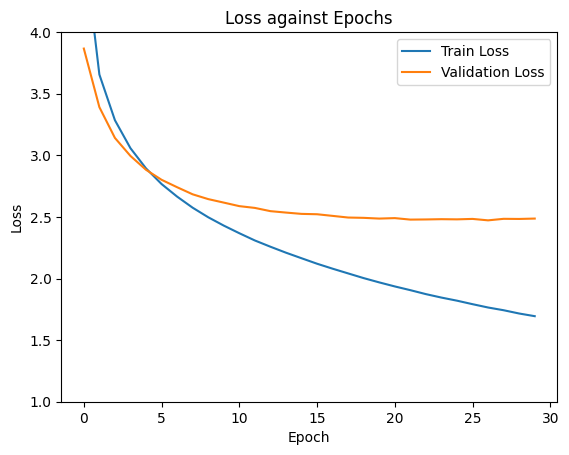

In [ ]:
import matplotlib.pyplot as plt

# Plotting the first line graph
plt.plot(train_loss, label='Train Loss')

# Plotting the second line graph
plt.plot(val_loss, label='Validation Loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss against Epochs')

# Adding legend
plt.legend()
plt.ylim([1, 4])

# Displaying the plot
plt.show()


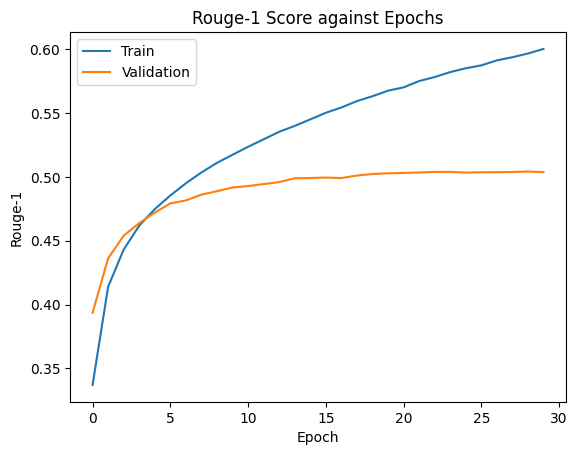

In [ ]:
rouge1_train =  [rouge_dict['rouge1'] for rouge_dict in train_rouge]
rouge1_val =  [rouge_dict['rouge1'] for rouge_dict in val_rouge]


# Plotting the first line graph
plt.plot(rouge1_train, label='Train')

# Plotting the second line graph
plt.plot(rouge1_val, label='Validation')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Rouge-1')
plt.title('Rouge-1 Score against Epochs')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()


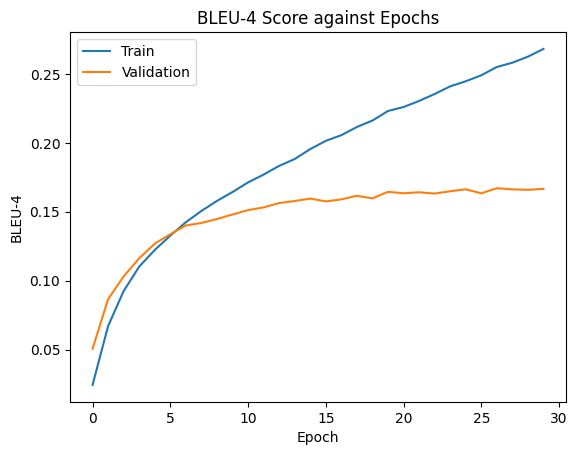

In [ ]:
bleu4_train =  [bleu_dict['BLEU4'] for bleu_dict in train_bleu]
bleu4_val =  [bleu_dict['BLEU4'] for bleu_dict in val_bleu]


# Plotting the first line graph
plt.plot(bleu4_train, label='Train')

# Plotting the second line graph
plt.plot(bleu4_val, label='Validation')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('BLEU-4')
plt.title('BLEU-4 Score against Epochs')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()


### Training with non finetuned InceptionV3

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#hyper parameters
feature_size = 2048
embed_size = 256 
hidden_size = 512
vocab_size = len(dataset.vocab)
num_layers = 3
learning_rate = 3e-4
num_epochs = 50
save_every = 25
model_name = "Flickr_Incept_NoPretrained"


print(device)

cuda


In [32]:
model = InceptV3EncoderAttentionDecoder(None,
                                feature_size,
                                embed_size, 
                                hidden_size, 
                                vocab_size, 
                                device,
                                0.3,
                                0).to(device)
criterion = torch.nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [33]:
train_loss, train_bleu, train_rouge, val_loss, val_bleu, val_rouge = train(
    model=model,
    criterion=criterion,
    optimiser=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    batch_first=True,
    vocabulary=dataset.vocab,
    device=device,
    num_epochs=num_epochs,
    show_train_metrics=True,
    save_every=25,
    model_name=model_name,
    overwrite=False
)

Epoch 5 completed
avg training loss per batch: 2.5934463544269963
train bleu score:{'BLEU1': 0.5644360664790232, 'BLEU2': 0.35378718504500245, 'BLEU3': 0.22142014250307007, 'BLEU4': 0.1363799581348385}
train rouge score: {'rouge1': 0.48056566298123504, 'rouge2': 0.21051218541822714, 'rougeL': 0.4519362585557799, 'rougeLsum': 0.45197646094178534}

avg validation loss per batch: 2.680668920516968
val bleu score: {'BLEU1': 0.5577584314873071, 'BLEU2': 0.35058482571264954, 'BLEU3': 0.22146527109321637, 'BLEU4': 0.13755191295881805}
val rouge score: {'rouge1': 0.4753830225933156, 'rouge2': 0.21165539246297227, 'rougeL': 0.44948089412908576, 'rougeLsum': 0.44938618583866285}
------------------------------------------------------------------
Epoch 10 completed
avg training loss per batch: 2.2138956347694787
train bleu score:{'BLEU1': 0.5990206638734664, 'BLEU2': 0.397593743257559, 'BLEU3': 0.26229044902375215, 'BLEU4': 0.16989145072473805}
train rouge score: {'rouge1': 0.5140550135484125, 'ro

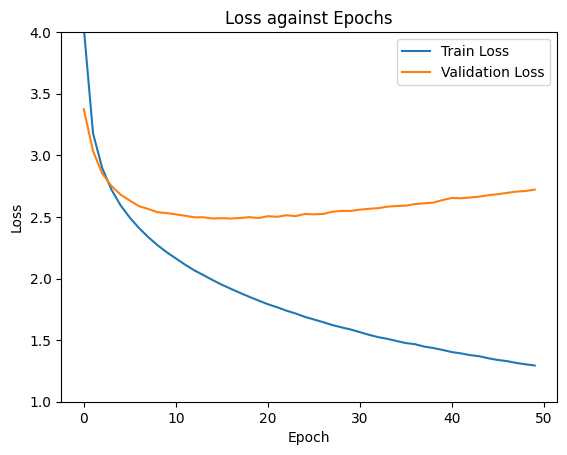

In [34]:
import matplotlib.pyplot as plt

# Plotting the first line graph
plt.plot(train_loss, label='Train Loss')

# Plotting the second line graph
plt.plot(val_loss, label='Validation Loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss against Epochs')

# Adding legend
plt.legend()
plt.ylim([1, 4])

# Displaying the plot
plt.show()

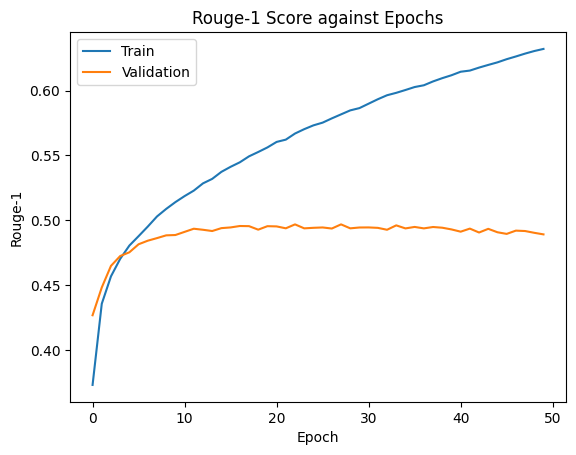

In [35]:
rouge1_train =  [rouge_dict['rouge1'] for rouge_dict in train_rouge]
rouge1_val =  [rouge_dict['rouge1'] for rouge_dict in val_rouge]


# Plotting the first line graph
plt.plot(rouge1_train, label='Train')

# Plotting the second line graph
plt.plot(rouge1_val, label='Validation')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Rouge-1')
plt.title('Rouge-1 Score against Epochs')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()


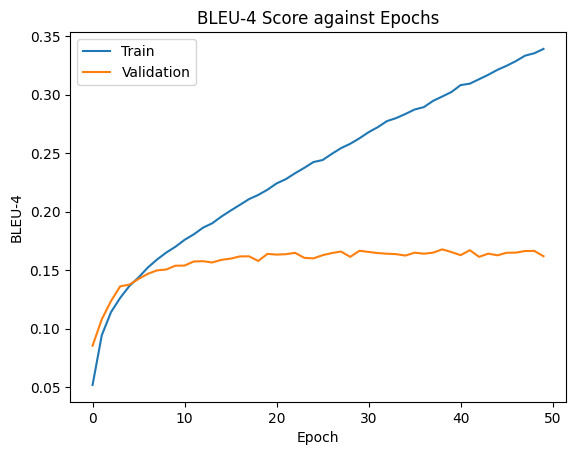

In [36]:
bleu4_train =  [bleu_dict['BLEU4'] for bleu_dict in train_bleu]
bleu4_val =  [bleu_dict['BLEU4'] for bleu_dict in val_bleu]


# Plotting the first line graph
plt.plot(bleu4_train, label='Train')

# Plotting the second line graph
plt.plot(bleu4_val, label='Validation')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('BLEU-4')
plt.title('BLEU-4 Score against Epochs')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()


### Training with finetuned InceptionV3

In [125]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#hyper parameters
feature_size = 2048
embed_size = 256 
hidden_size = 512
vocab_size = len(dataset.vocab)
num_layers = 3
learning_rate = 3e-4
num_epochs = 50
save_every = 25
model_name = "Flickr_Incept_Pretrained"


print(device)

cuda


In [128]:
inception_pretrained = torch.load('../models/cnn/inceptV3/incept_10_30.pt')

In [129]:
model = InceptV3EncoderAttentionDecoder(inception_pretrained,
                                feature_size,
                                embed_size, 
                                hidden_size, 
                                vocab_size, 
                                device,
                                0.3,
                                0).to(device)
criterion = torch.nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [130]:
train_loss, train_bleu, train_rouge, val_loss, val_bleu, val_rouge = train(
    model=model,
    criterion=criterion,
    optimiser=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    batch_first=True,
    vocabulary=dataset.vocab,
    device=device,
    num_epochs=num_epochs,
    show_train_metrics=True,
    save_every=25,
    model_name=model_name,
    overwrite=False
)

Epoch 5 completed
avg training loss per batch: 2.5811137967097486
train bleu score:{'BLEU1': 0.5657595830598158, 'BLEU2': 0.35573710459782754, 'BLEU3': 0.22310844977665578, 'BLEU4': 0.13770998899507852}
train rouge score: {'rouge1': 0.4831911042076628, 'rouge2': 0.21399445396109767, 'rougeL': 0.4550901093381147, 'rougeLsum': 0.4550565932206652}

avg validation loss per batch: 2.6804780769348144
val bleu score: {'BLEU1': 0.5554700093833458, 'BLEU2': 0.35085627770062733, 'BLEU3': 0.22269874554992894, 'BLEU4': 0.13895938864834886}
val rouge score: {'rouge1': 0.47807921338860343, 'rouge2': 0.2160274867883748, 'rougeL': 0.4513549861620072, 'rougeLsum': 0.4514454234476057}
------------------------------------------------------------------
Epoch 10 completed
avg training loss per batch: 2.205948169731423
train bleu score:{'BLEU1': 0.597992146622751, 'BLEU2': 0.3975411692188452, 'BLEU3': 0.2631766286563036, 'BLEU4': 0.1711743944259418}
train rouge score: {'rouge1': 0.5156336156628223, 'rouge2'

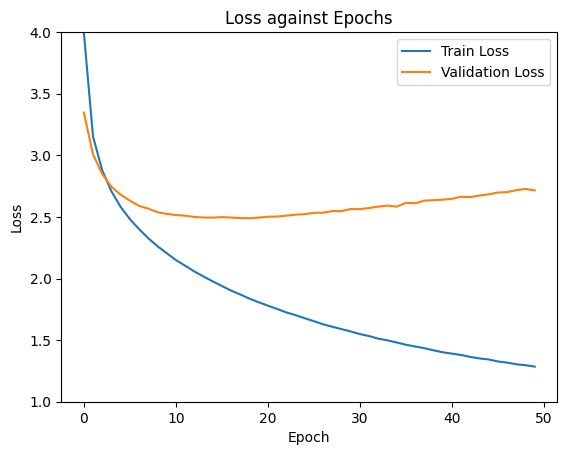

In [131]:
import matplotlib.pyplot as plt

# Plotting the first line graph
plt.plot(train_loss, label='Train Loss')

# Plotting the second line graph
plt.plot(val_loss, label='Validation Loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss against Epochs')

# Adding legend
plt.legend()
plt.ylim([1, 4])

# Displaying the plot
plt.show()

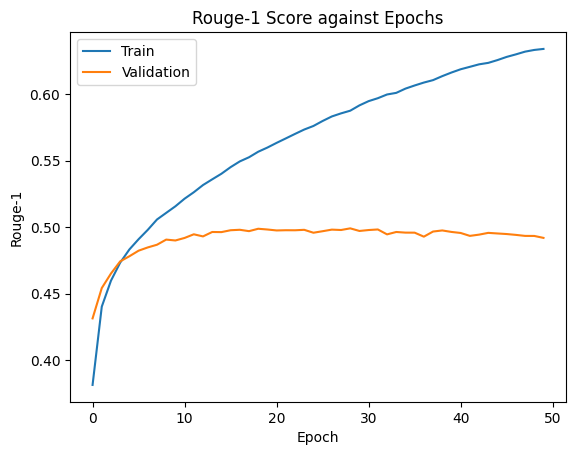

In [132]:
rouge1_train =  [rouge_dict['rouge1'] for rouge_dict in train_rouge]
rouge1_val =  [rouge_dict['rouge1'] for rouge_dict in val_rouge]


# Plotting the first line graph
plt.plot(rouge1_train, label='Train')

# Plotting the second line graph
plt.plot(rouge1_val, label='Validation')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Rouge-1')
plt.title('Rouge-1 Score against Epochs')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()


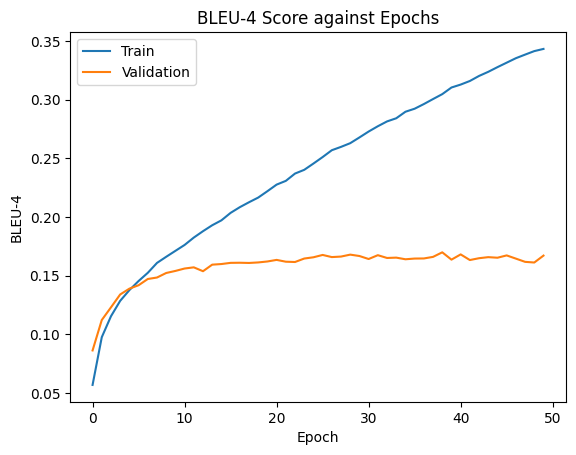

In [133]:
bleu4_train =  [bleu_dict['BLEU4'] for bleu_dict in train_bleu]
bleu4_val =  [bleu_dict['BLEU4'] for bleu_dict in val_bleu]


# Plotting the first line graph
plt.plot(bleu4_train, label='Train')

# Plotting the second line graph
plt.plot(bleu4_val, label='Validation')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('BLEU-4')
plt.title('BLEU-4 Score against Epochs')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()


### EVALUATION

In [90]:
test_model = InceptV3EncoderAttentionDecoder(feature_size, embed_size, hidden_size, vocab_size, device).to(device)
test_criterion = torch.nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
test_model.load_state_dict(torch.load('../models/image_captioning/Flickr_Incept_NoPretrained_50.pt'))

<All keys matched successfully>

In [ ]:
#loading example model
test_model2 = ResNetEncoderAttentionDecoder(pretrained_model, feature_size, embed_size, hidden_size, vocab_size, device).to(device)
test_criterion2 = torch.nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
test_model2.load_state_dict(torch.load('../models/image_captioning/Flickr_Pretrained_20_50.pt'))

<All keys matched successfully>

In [89]:
#loading example model
test_model3 = ResNetEncoderAttentionDecoder(pretrained_model, feature_size, embed_size, hidden_size, vocab_size, device).to(device)
test_criterion3 = torch.nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
test_model3.load_state_dict(torch.load('../models/image_captioning/Flickr_Pretrained_11.pt'))

<All keys matched successfully>

In [79]:
test_loss, test_bleu, test_rouge = eval(
    model=test_model2,
    criterion=test_criterion2,
    dataloader=test_dataloader,
    batch_first=True,
    vocabulary=test_dataset.vocab,
    device=device
)

print(f"Test Loss: {test_loss}\nTest BLEU:{test_bleu}\nTest Rouge:{test_rouge}")

Test Loss: 5.093483141128053
Test BLEU:{'BLEU1': 0.4679077639094563, 'BLEU2': 0.2561589085769278, 'BLEU3': 0.1344233855771734, 'BLEU4': 0.06764615384627981}
Test Rouge:{'rouge1': 0.3958397663627844, 'rouge2': 0.14068040185700864, 'rougeL': 0.3635726730647214, 'rougeLsum': 0.36357642417353786}


In [31]:
test_loss, test_bleu, test_rouge = eval(
    model=test_model3,
    criterion=test_criterion3,
    dataloader=test_dataloader,
    batch_first=True,
    vocabulary=test_dataset.vocab,
    device=device
)

print(f"Test Loss: {test_loss}\nTest BLEU:{test_bleu}\nTest Rouge:{test_rouge}")

Test Loss: 4.699357950941045
Test BLEU:{'BLEU1': 0.4734225621414914, 'BLEU2': 0.2609712972620346, 'BLEU3': 0.13572057563529408, 'BLEU4': 0.06781350948933866}
Test Rouge:{'rouge1': 0.40044727809248154, 'rouge2': 0.1417391026735017, 'rougeL': 0.3661075513956653, 'rougeLsum': 0.3661827274345326}


### INFERENCE

In [62]:
#Assuming mean and std are defined as follows:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def unnormalize(image:np.array, mean:np.array, std:np.array):
    """
    Function to unnormalize an image given its mean and std
    
    Args: 
        image (np.array): Numpy array of the image
        mean (np.array): Numpy array of the mean 
        std (np.array): Numpy array of the std

    Returns:
        Unnormalised numpy array of the image
    """

    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)    # for inplace operations
    return image


def caption_image(model, dataloader, vocabulary:Vocabulary, device:str, mean:np.array=np.array([0.485, 0.456, 0.406]), std:np.array=np.array([0.229, 0.224, 0.225]), num_batches:int=1, num_images:int=5, max_length:int=50, show_plot:bool=False):
    """
    Function to generate model predictions from a dataloader

    Arg:
        model: model to general model prediction (ensure that your model has the function caption_image)
        dataloader: dataset to generate prediction
        vocabulary (Vocabulary): dataset vocabulary
        device (str): cpu or cuda,
        mean (np.array): Numpy array of the mean used for normalisation
        std (np.array): Numpy array of the std used for normalisation
        num_batches (int, optional): how many batches iterating from dataloader, defaults to 1
        num_image (int, optional): how many images per batch to generate model prediction, defaults to 5
        max_length (int, optional): maximum length of generated captions, defaults to 50
        show_plot (bool, optional): show the image and generated captions in a plot, defaults to False
    
    Returns:
        all_predictions (dict): Dictionary containing the list of all generated captions and actual captions
    
    """
    model.eval()
    #dictionary containing all the generated predictions and actual predictions
    all_predictions = {'Predicted': [], 'Possible Captions': []}

    #iterate for num of batches we are testing
    for j in range(num_batches):
        #load images from dataloader
        features, annotations, all_annotations = next(iter(dataloader))
        
        #take first k from batch
        for i in range(num_images):
            image = features[i].unsqueeze(0).to(device)
            
            #generate captions from model
            generated_caption, attention = model.caption_image(image, vocabulary, device, max_length=max_length)
            
            #plot image and captions
            if show_plot:
                fig, ax = plt.subplots(figsize=(5, 5))
                img = features[i].squeeze()
                img = unnormalize(img, mean, std)  # Unnormalize the image
                img = np.transpose(img.numpy(), (1, 2, 0))
                ax.imshow(img)
                ax.axis('off')
                ax.set_title(f'Model Prediction:\n{" ".join(generated_caption[1:-1])}\n\nAll Possible Predictions:\n' + "\n".join(all_annotations[i]), loc='left')

                plt.tight_layout()
                plt.show()

            all_predictions['Predicted'].append(generated_caption)
            all_predictions['Possible Captions'].append(all_annotations[i])

    return all_predictions


def multiple_model_captions(model_list, dataloader, vocabulary:Vocabulary, device:str, mean:np.array=np.array([0.485, 0.456, 0.406]), std:np.array=np.array([0.229, 0.224, 0.225]), num_batches:int=1, num_images:int=5, max_length:int=50, show_plot:bool=False):
    """
    Function to generate model predictions for multiple models from the same dataloader

    Arg:
        model_list: list of model to general model prediction (ensure that your model has the function caption_image)
        dataloader: dataset to generate prediction
        vocabulary (Vocabulary): dataset vocabulary
        device (str): cpu or cuda,
        mean (np.array): Numpy array of the mean used for normalisation
        std (np.array): Numpy array of the std used for normalisation
        num_batches (int, optional): how many batches iterating from dataloader, defaults to 1
        num_image (int, optional): how many images per batch to generate model prediction, defaults to 5
        max_length (int, optional): maximum length of generated captions, defaults to 50
        show_plot (bool, optional): show the image and generated captions in a plot, defaults to False
    
    Returns:
        all_predictions (dict): Dictionary containing the dictionary of all generated captions for each model and list of actual captions
    
    """
    for model in model_list:
        model.eval()

    #dictionary containing all the generated predictions and actual predictions
    all_predictions = {'Predicted': {}, 'Possible Captions': []}

    #iterate for num of batches we are testing
    for j in range(num_batches):
        #load images from dataloader
        features, annotations, all_annotations = next(iter(dataloader))
        
        #take first k from batch
        for i in range(num_images):
            image = features[i].unsqueeze(0).to(device)
            all_captions = []

            for idx, model in enumerate(model_list):
                #generate captions from model
                generated_caption, attention = model.caption_image(image, vocabulary, device, max_length=max_length)
                all_captions.append(" ".join(generated_caption[1:-1]))
                model_predictions = all_predictions['Predicted'].get(f"model_{idx}", [])
                model_predictions.append(all_captions)
                all_predictions['Predicted'][f"model_{idx}"] = model_predictions

            #plot image and captions
            if show_plot:
                fig, ax = plt.subplots(figsize=(5, 5))
                img = features[i].squeeze()
                img = unnormalize(img, mean, std)  # Unnormalize the image
                img = np.transpose(img.numpy(), (1, 2, 0))
                ax.imshow(img)
                ax.axis('off')

                pred = '\n'.join(all_captions)
                annotation = '\n'.join(all_annotations[i])

                ax.set_title(f'All Model Predictions:\n{pred}\n\nAll Possible Predictions:\n{annotation}', loc='left')

                plt.tight_layout()
                plt.show()

            all_predictions['Possible Captions'].append(all_annotations[i])

    return all_predictions

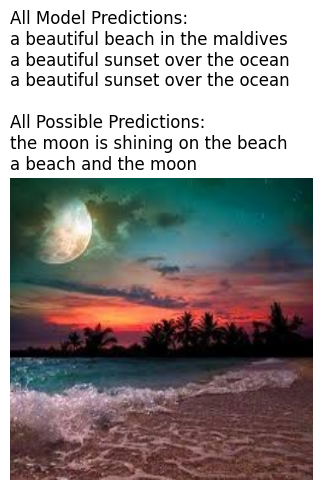

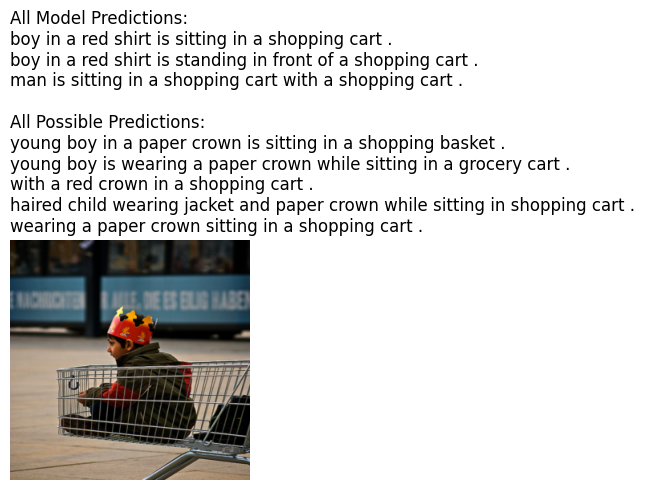

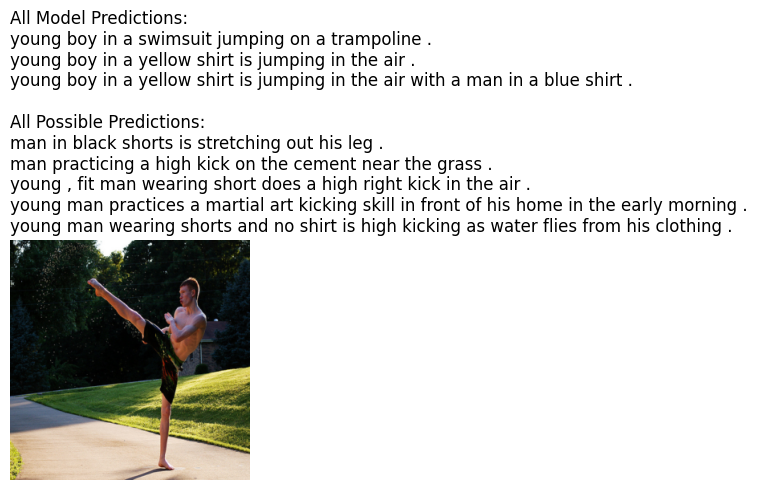

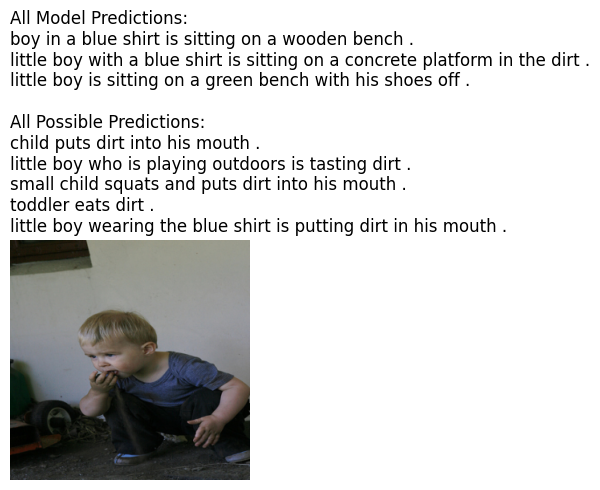

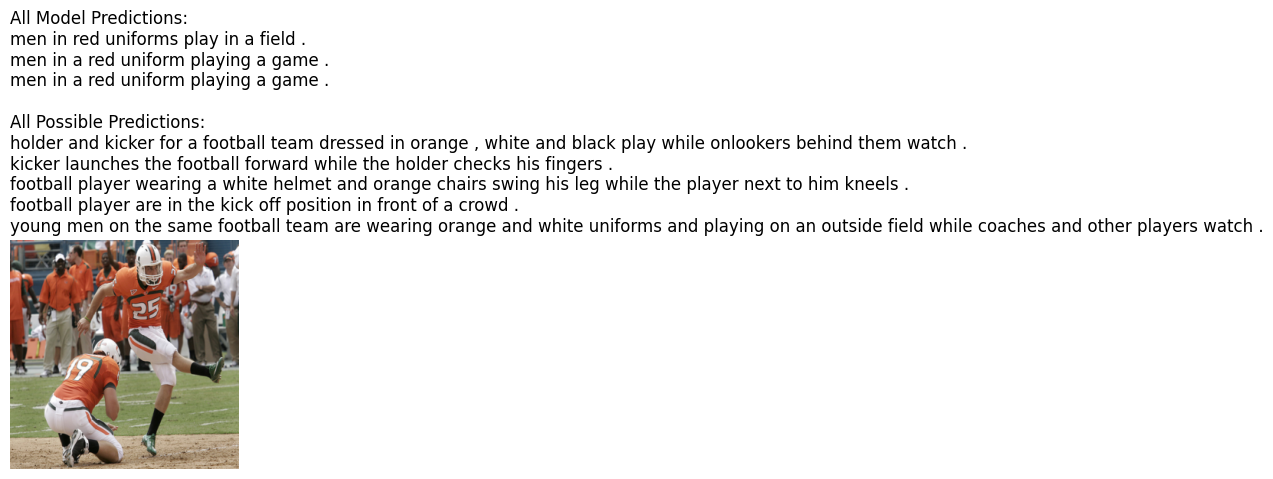

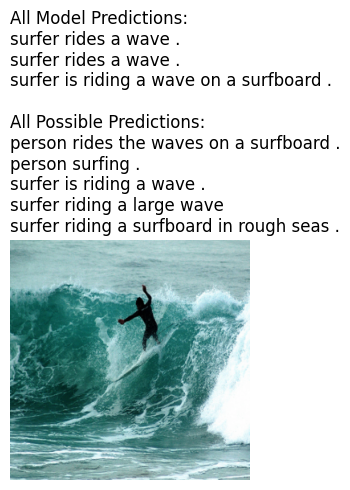

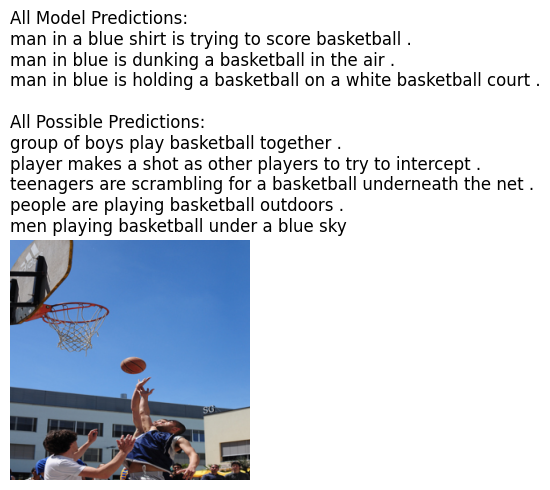

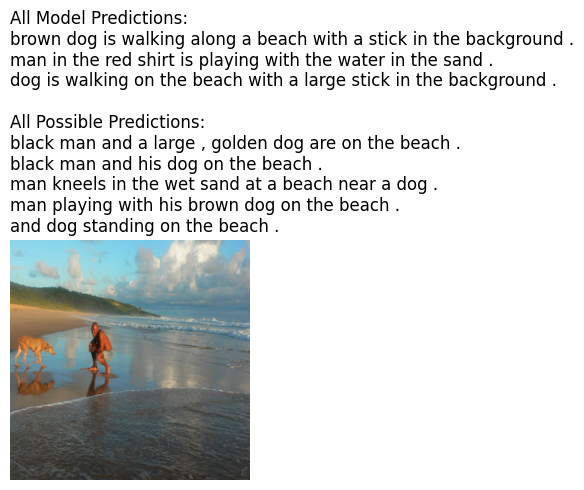

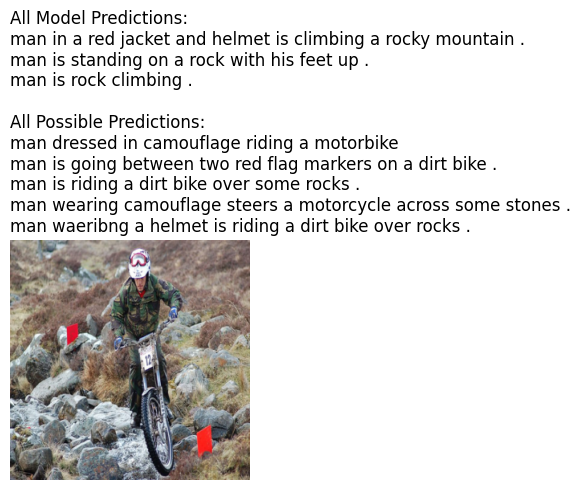

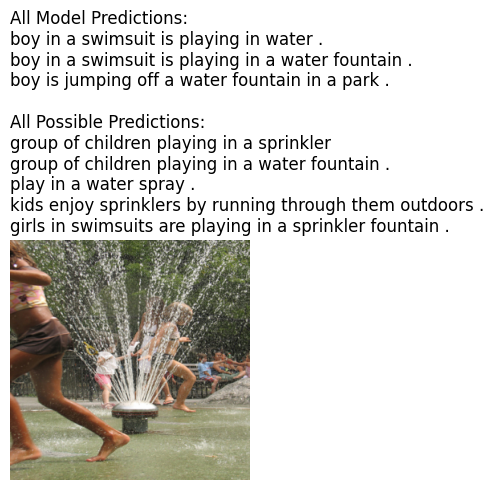

In [87]:
predictions = multiple_model_captions(
    model_list=[test_model, test_model2, test_model3],
    dataloader=test_dataloader,
    vocabulary= test_dataset.vocab,
    device=device,
    mean=mean,
    std=std,
    num_batches=10,
    num_images=1,
    max_length=50,
    show_plot=True
)

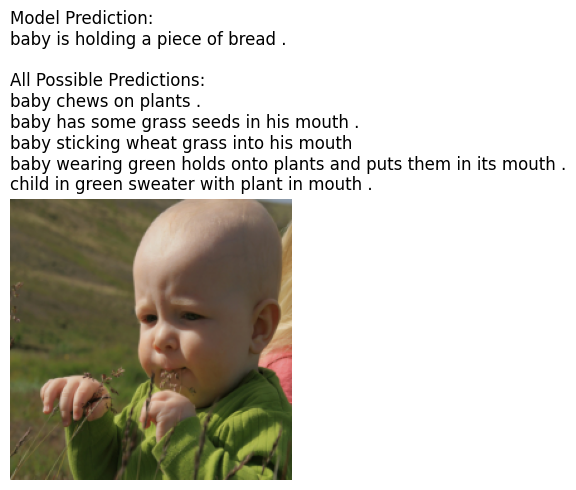

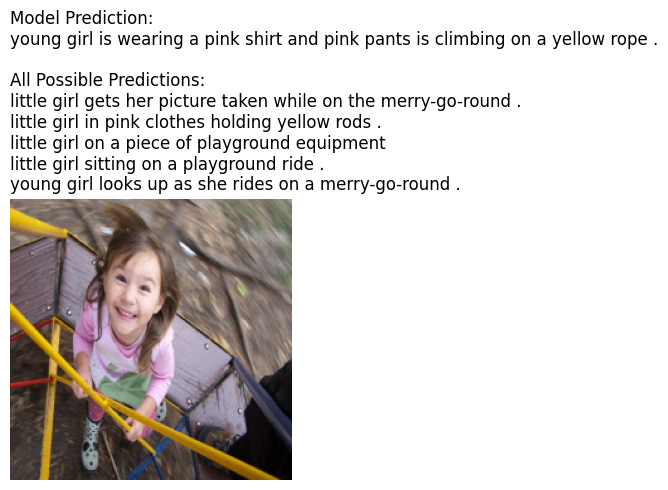

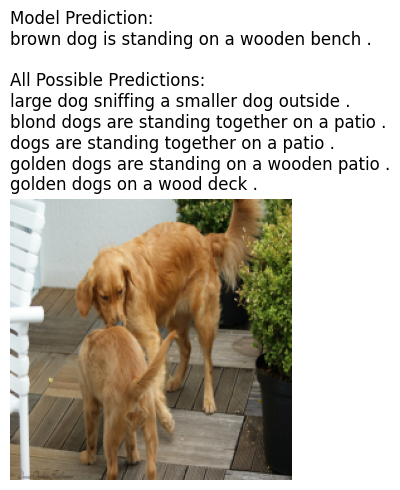

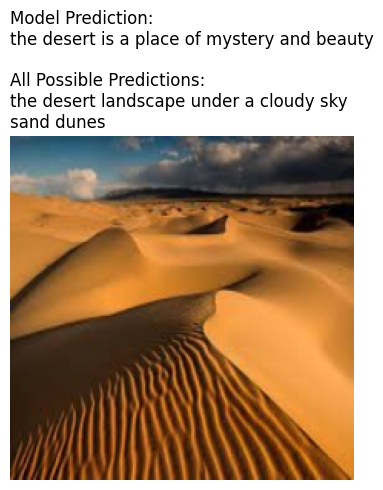

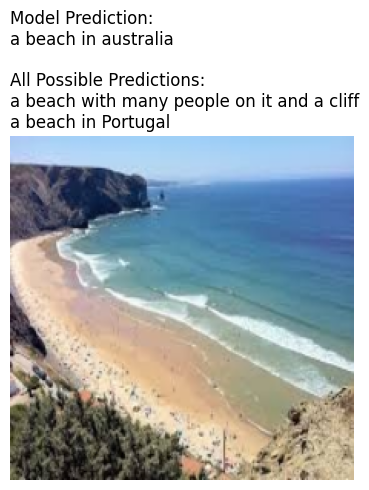

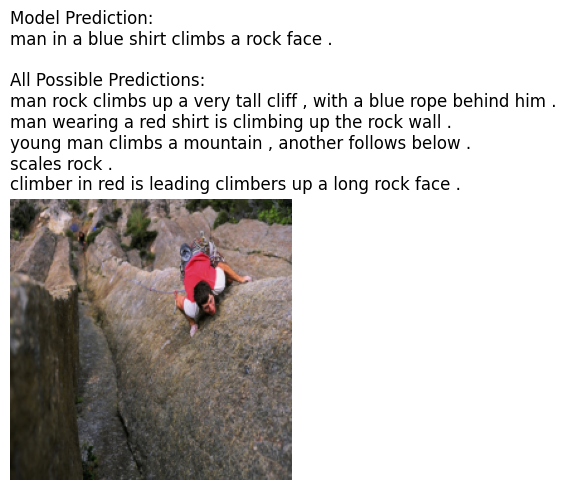

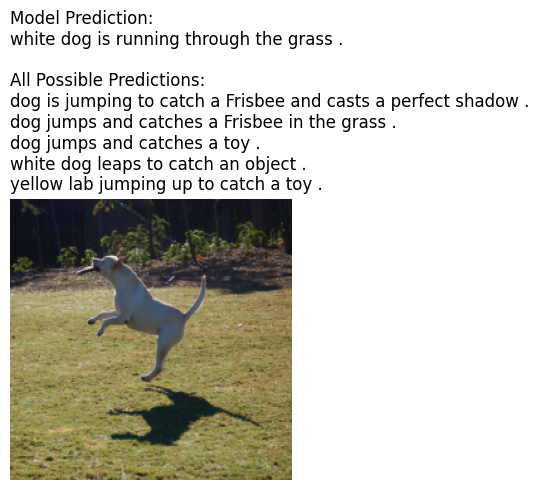

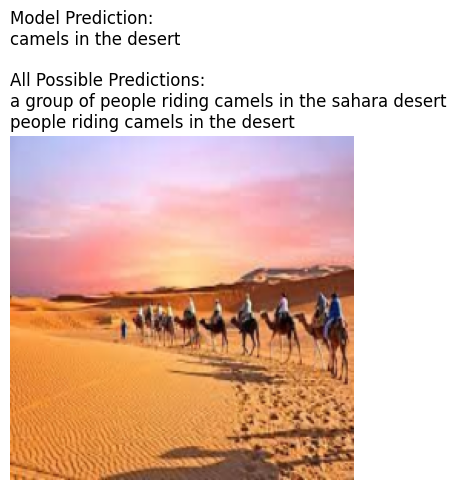

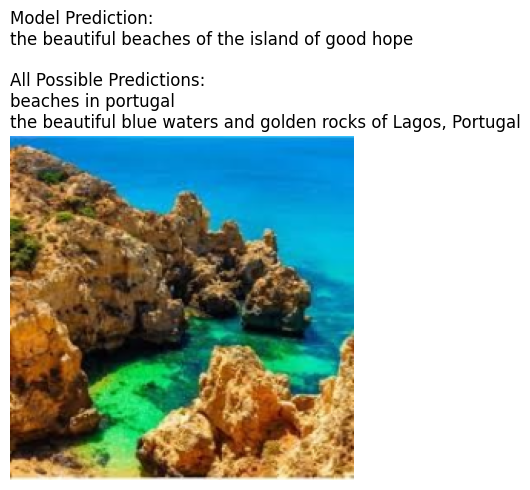

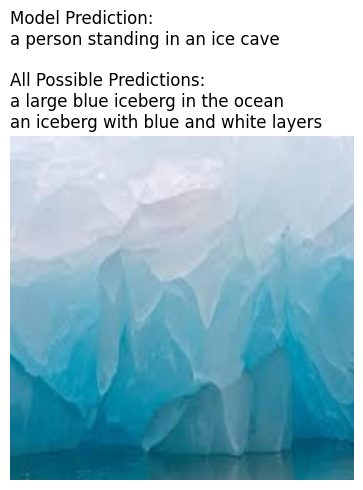

In [62]:
predictions = caption_image(
    model=test_model3,
    dataloader=test_dataloader,
    vocabulary=test_dataset.vocab,
    device=device,
    mean=mean,
    std=std,
    num_batches=1,
    num_images=10,
    max_length=50,
    show_plot=True
)